In [1]:
import os
import logging
import warnings
import numpy as np
import pandas
import SimpleITK as sitk

from config import config
from multiprocessing import Pool
from functools import partial
from pp_utils import resample, load_itk_image, display, get_box_from_mask, normalize, worldToVoxelCoord

%matplotlib inline

In [2]:
def savenpy_luna(id, annos, filelist, luna_segment, luna_data, savepath, resolution, force=True):
    
    name = filelist[id]
    bone_thresh = int(config['pp_bone_threshold'])
    pad_value = int(config['pp_pad_value'])
        
    if force != True:
        if os.path.exists(os.path.join(savepath,name+'_label.npy')) and os.path.exists(os.path.join(savepath,name+'_clean.npy')):
            print(name +' had been done')
            return
    
    try:
        # load lung segmentation mask data given with dataset
        mask, origin, spacing,_ = load_itk_image(os.path.join(luna_segment,name+'.mhd'))
        m1 = mask==3
        m2 = mask==4
        mask = m1+m2
        mask,_ = resample(mask, spacing, resolution)
#         display(mask[int(np.floor(100*spacing[0]/resolution[0]))], 'mask')
        
        # calculate the inflated bounding box for lungs
        box_coord = get_box_from_mask(mask)
        
        # load scan
        scan_or, origin, spacing, isflip = load_itk_image(os.path.join(luna_data,name+'.mhd'))
        scan, new_spacing = resample(scan_or, spacing, resolution)
        scan = normalize(scan)
#         display(scan[int(np.floor(100*spacing[0]/resolution[0]))], 'scan')
        
        # clean scan + cut bbox
        clean_scan = (scan * mask + pad_value * (1 - mask)).astype('uint8')
#         np.save(os.path.join(savepath,name+'_clean.npy'), clean_scan)
        bones = (clean_scan * mask) > bone_thresh
        clean_scan[bones] = pad_value
        boxed_scan = clean_scan[box_coord[0,0]:box_coord[0,1],
                    box_coord[1,0]:box_coord[1,1],
                    box_coord[2,0]:box_coord[2,1]]
#         display(boxed_scan[int(np.floor(100*spacing[0]/resolution[0]))-box_coord[0,0]], int(np.floor(100*spacing[0]/resolution[0]))-box_coord[0,0])
        
        # add a 4th dimension before saving
#         save_scan = boxed_scan[np.newaxis,...]
#         np.save(os.path.join(savepath,name+'_clean.npy'), save_scan)
        itkimage = sitk.GetImageFromArray(boxed_scan)
        itkimage.SetSpacing(new_spacing)
        itkimage.SetOrigin([0,0,0])
        sitk.WriteImage(itkimage, os.path.join(savepath,name+'.mhd'), True) 

        this_annos = np.copy(annos[annos[:,0]==name])
        label = []
        if len(this_annos)>0:
            for c in this_annos:
#                 test = np.absolute(c[1:4][::-1] - origin) / spacing
#                 display(scan_or[int(test[0])], test)
                pos = worldToVoxelCoord(c[1:4][::-1], origin, spacing, resolution)
                if isflip:
                    pos[1:] = clean_scan.shape[1:3]-pos[1:]
                label.append(np.concatenate([pos,[c[4]]]))
#                 display(scan[int(pos[0])], '', pos)

        label = np.array(label)
        if len(label)==0:
            label2 = np.array([[0,0,0,0]])
        else:
            label2 = np.copy(label).T
            label2[:3] = label2[:3]-np.expand_dims(box_coord[:,0],1)
            label2 = label2[:4].T
            for it in label2:
                display(boxed_scan[int(it[0])], int(it[0]), '', it)
        np.save(os.path.join(savepath,name+'_label.npy'),label2)

    except:
        print('bug in '+name)
        raise
    print(name+' done')

In [3]:
def preprocess_luna():
    luna_segment = config['luna_segment']
    savepath = config['preprocess_result_path']
    luna_data = config['luna_raw']
    luna_label = config['luna_label']
    resolution = np.fromstring(config['pp_resolution'][1:-1], sep=',')
    finished_flag = '.flag_preprocessluna'
    
    print('starting preprocessing luna')
    
    if not os.path.exists(finished_flag):
        filelist = [f.split('.mhd')[0] for f in os.listdir(luna_data) if f.endswith('.mhd') ]
        annos = np.array(pandas.read_csv(luna_label))
        if not os.path.exists(savepath):
            os.mkdir(savepath)
        
        pool = Pool()
#         partial_savenpy_luna = partial(savenpy_luna, annos=annos, filelist=filelist,
#                                        luna_segment=luna_segment, luna_data=luna_data, savepath=savepath)
        N = len(filelist)
        savenpy_luna(0, annos=annos, filelist=filelist, luna_segment=luna_segment, luna_data=luna_data, 
                     savepath=savepath, resolution=resolution, force=True)
#         _=pool.map(partial_savenpy_luna,range(N))
#         pool.close()
#         pool.join()
    print('end preprocessing luna')
#     f= open(finished_flag,"w+")

starting preprocessing luna


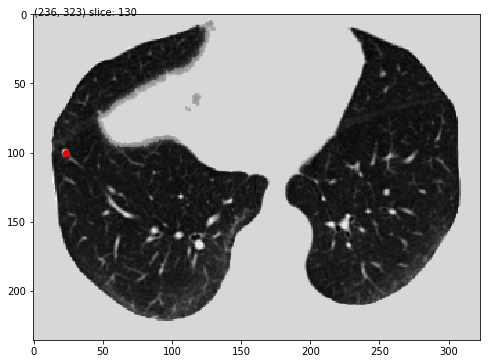

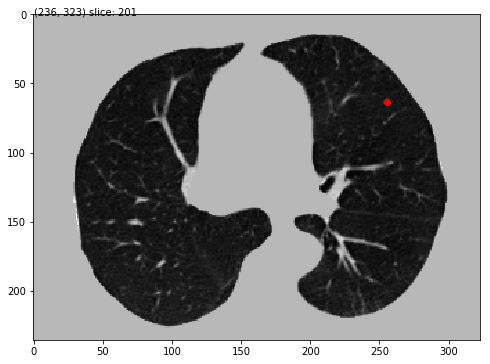

1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860 done
end preprocessing luna
Wall time: 13.9 s


In [4]:
%%time

import warnings
warnings.filterwarnings("ignore")
logging.basicConfig(filename='pp_log.log', format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.WARNING)
preprocess_luna()

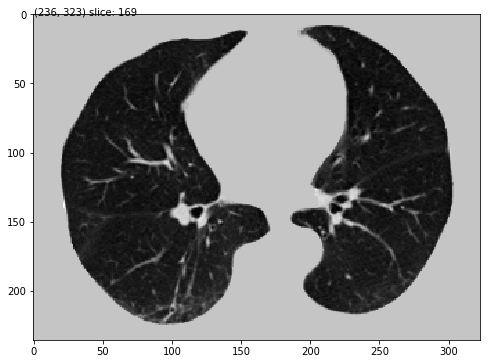

In [5]:
savepath = config['preprocess_result_path']

filelist = [f.split('.mhd')[0] for f in os.listdir(savepath) if f.endswith('.mhd') ]
name = filelist[0]
scan_or, origin, spacing, isflip = load_itk_image(os.path.join(savepath,name+'.mhd'))
display(scan_or[169],169)